# Metric Learning

In [ ]:
# !pip3 install opendatasets
# !pip3 install omegaconf
# !pip3 install pytorch-lightning
# !pip3 install pytorch-metric-learning
# !pip3 install wandb
# !git clone https://github.com/pskiers/Metric-Learning-KL-loss.git
# !mv /content/Metric-Learning-KL-loss/configs /content/Metric-Learning-KL-loss/data_utils /content/Metric-Learning-KL-loss/model /content

In [1]:
import torch
import torchvision.transforms as transforms
from data_utils import cub2011
from data_utils import stanford_cars

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.2) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
IMAGE_SIZE = 224

## Download data

### Download datasets
We are downloading two benchmark datasets:
* Stanford-Cars (CARS 196) - https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder
* CUB 200 2011 - https://www.kaggle.com/datasets/wenewone/cub2002011

and make basic transformations, including input normalization.

In [5]:
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

batch_size = 32

In [6]:
cars_trainset = stanford_cars.download_cars('./data', train=True, download=True, transforms=train_transform)
cars_testset = stanford_cars.download_cars('./data', train=False, download=False, transforms=transform)

cub_trainset = cub2011.download_cub('./data', train=True, download=True, transforms=train_transform)
cub_testset = cub2011.download_cub('./data', train=False, download=False, transforms=transform)

Skipping, found downloaded files in "./data/stanford-car-dataset-by-classes-folder" (use force=True to force download)
folder already exits in given location: ./data/stanford-car-dataset-by-classes-folder
Skipping, found downloaded files in "./data/cub2002011" (use force=True to force download)
folder already exits in given location: ./data/cub2002011


In [7]:
cars_trainloader = torch.utils.data.DataLoader(cars_trainset, batch_size=batch_size,
                                          shuffle=True, drop_last=True)
cars_testloader = torch.utils.data.DataLoader(cars_testset, batch_size=batch_size,
                                          shuffle=False, drop_last=True)
cub_trainloader = torch.utils.data.DataLoader(cub_trainset, batch_size=batch_size,
                                          shuffle=True, drop_last=True)
cub_testloader = torch.utils.data.DataLoader(cub_testset, batch_size=batch_size,
                                          shuffle=False, drop_last=True)

### Visualize fetched data

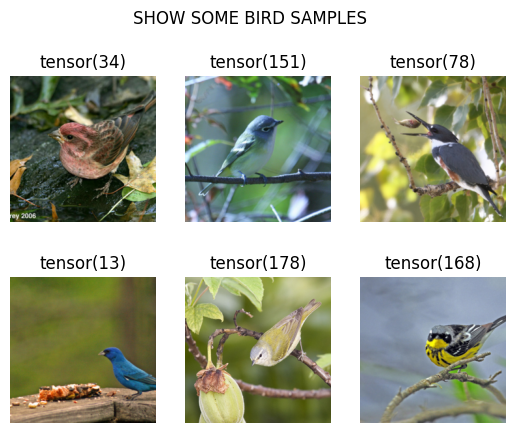

In [8]:
images, labels = next(iter(cub_trainloader))
cub2011.show_samples(images[0:6], labels[0:6], 2, 3, 'SHOW SOME BIRD SAMPLES')

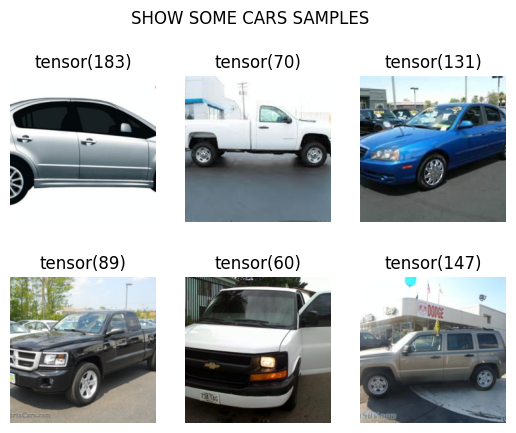

In [9]:
images, labels = next(iter(cars_trainloader))
cub2011.show_samples(images[0:6], labels[0:6], 2, 3, 'SHOW SOME CARS SAMPLES')

## Network

In [3]:
from os import path
from omegaconf import OmegaConf
from model.model import KLLossMetricLearning
import pytorch_lightning as pl
from pytorch_lightning.loggers.wandb import WandbLogger
from datetime import datetime

### Configuration

With usage of gridsearch the research was conducted on impact of chosen hyperparameters on the training of the ResNet based ANN. The grid was constructed for the values as follow:
| Hyperparameter | Configuration name | Tested values |
| :---: | :---: | :---: |
| Expected class distance (m) | *exp_class_distance* | {1, 10} |
| Regularization ratio (alpha) | *regularization_ratio* | {0.00001, 0.01, 0.2} |
| Batch: Positive to Negative ratio | *pos_neg_ration* | {0.05, 1} |

In [ ]:
raise Exception("Are you sure you want to process with external current model configuration?") 
#catcher for "run all" option

In [ ]:
conf_path = path.join("configs", "model_cub.yaml")
conf = OmegaConf.load(conf_path)
model = KLLossMetricLearning(**conf.get("model"))

In [ ]:
pl.seed_everything(42)
now = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
nowname = model.__class__.__name__ + "_" + now
logdir = path.join("logs", nowname)
ckptdir = path.join(logdir, "checkpoints")
default_modelckpt_cfg = {
    "dirpath": ckptdir,
    "filename": "{epoch:06}",
    "verbose": True,
    "save_last": True,
    "monitor": "val/loss",
    "save_top_k": 1,
    # "mode": "max",
}
callbacks = [pl.callbacks.ModelCheckpoint(**default_modelckpt_cfg)]
logger = WandbLogger(
    project="ZZSN",
    name=nowname,
    log_model=True,
    id=nowname,
    # group=str(group),
    reinit=True,
    allow_val_change=True
)

### Training & Testing
Training and testing of the model was supported by a wrappers provided by *pytorch lightning* library. The metrics are in real time exported to the given wandb.com account for further analysis and visualization.

In [ ]:
trainer = pl.Trainer(logger=logger, callbacks=callbacks, max_epochs=15)
trainer.fit(
    model, train_dataloaders=cub_trainloader, val_dataloaders=cub_testloader
)

In [ ]:
trainer.test(model, cars_testloader)